In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# LOADING THE DATA

In [31]:
import os
import zipfile

In [6]:
os.makedirs("/content/data")

In [32]:
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/AI lab: final project/groceries.zip", 'r') as zf:
    zf.extractall("/content/data")

In [33]:
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/AI lab: final project/recipes.zip", 'r') as zf:
    zf.extractall("/content")

In [ ]:
pip install torchmetrics

# CREATING THE MODEL



In [67]:
import cv2
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torchmetrics
import math
import ast
import textwrap
import matplotlib.image as img
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

RESIZE THE IMAGES

    This part recursevely visits all the file directories. It resizes all the images,
    converts them to the same format and saves the result images to resized_images folder

In [37]:
def resize_images(source_folder, output_folder, new_size=(128, 128)):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for item in os.listdir(source_folder):
        source_path = source_folder + "/"+ item
        output_path = output_folder + "/" + item

        if os.path.isfile(source_path):
            try:
                with Image.open(source_path) as img:
                    # Handling palette images with transparency
                    if img.mode == "P":
                        img = img.convert("RGBA")  # Convert to RGBA and then convert to RGB
                        img = img.convert("RGB")

                    elif img.mode == "RGBA":
                        img = img.convert("RGB")

                    resized_img = img.resize(new_size, Image.LANCZOS)
                    resized_img.save(output_path)

                    #os.remove(source_path) # Remove the original images
            except Exception as e:
                print(f"File error {source_path}: {e}")

        elif os.path.isdir(source_path):

            new_output_folder = output_folder + "/" + item
            resize_images(source_path, new_output_folder, new_size)

source_path = "/content/data"
output_path = "/content/resized_images"

resize_images(source_path, output_path)

    Define hyperparameters

In [38]:
epochs = 15
batch_size = 25
learning_rate = 0.001

    Loading the training, testing and validating datasets

In [39]:
training_data = ImageFolder(root="/content/resized_images/train", transform=transforms.ToTensor())
test_data = ImageFolder(root="/content/resized_images/test", transform=transforms.ToTensor())
validation_data = test_data = ImageFolder(root="/content/resized_images/validation", transform=transforms.ToTensor())

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

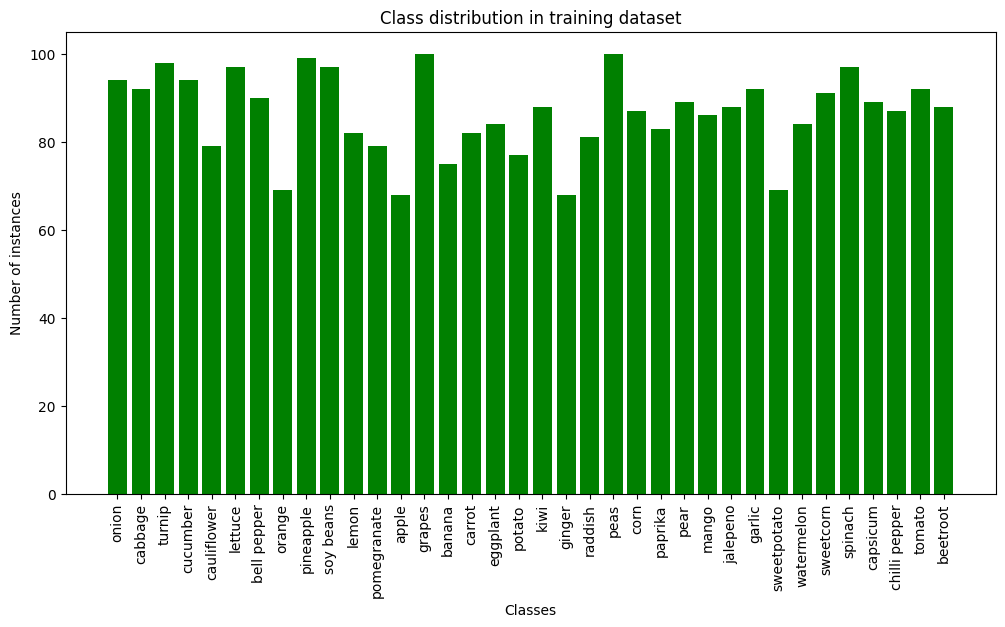

In [44]:
def count_classes(dataloader):

    class_counts = Counter()  # Initialize a new Counter each time

    for _, labels in dataloader:
        class_counts.update(labels.numpy())
    return class_counts

class_counts = count_classes(train_dataloader)

class_indices = list(class_counts.keys())
counts = list(class_counts.values())

# Convert class indices to class names
class_names = training_data.classes
class_labels = [class_names[i] for i in class_indices]

plt.figure(figsize=(12, 6))
plt.bar(class_labels, counts, color='green')

plt.xlabel('Classes')
plt.ylabel('Number of instances')
plt.title('Class distribution in training dataset')
plt.xticks(rotation=90)
plt.show()

MODEL
    
    creating a CCN model to train the dataset

In [45]:
class MyCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn = nn.Sequential(

      nn.Conv2d(3,5,3),
      nn.ReLU(),
      nn.Conv2d(5,10,3),
      nn.ReLU(),
      nn.MaxPool2d(2)
    )

    self.mlp = nn.Sequential(

      nn.Linear(10*62*62,10),
      nn.Linear(10,36)

      )

  def forward(self,x):

      x = self.cnn(x)
      x = torch.flatten(x,1)
      x = self.mlp(x)
      return x

In [46]:
model = MyCNN()

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate)


In [48]:
# Accucary metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=36)


    Define the training loop

In [49]:
def train_loop(dataloader, model,loss_fn,optimizer):

  for batch,(X,y) in enumerate(dataloader):

    pred = model(X)
    loss = loss_fn(pred,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 20 == 0:
      acc = metric(pred,y)
      print(f"accuracy current batch: {acc}")

  acc = metric.compute()
  print(f"training final accuracy for each epoch : {acc}")
  metric.reset()

    Define the test loop

In [50]:
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader)
  num_batches = len(dataloader)
  test_loss, correct = 0,0

  with torch.no_grad():
    for X,y in dataloader:
      pred = model(X)
      acc = metric(pred,y)
  acc = metric.compute()
  print(f"testing final accuracy for each epoch : {acc}")
  metric.reset()


MODEL TRAINING

In [51]:
for t in range(epochs):
  print(f"epoch: {t}")
  train_loop(train_dataloader,model, loss_fn,optimizer)
  test_loop(test_dataloader,model,loss_fn)

epoch: 0
accuracy current batch: 0.0
accuracy current batch: 0.07999999821186066
accuracy current batch: 0.03999999910593033
accuracy current batch: 0.1599999964237213
accuracy current batch: 0.03999999910593033
accuracy current batch: 0.07999999821186066
accuracy current batch: 0.03999999910593033
training final accuracy for each epoch : 0.06285714358091354
testing final accuracy for each epoch : 0.14529915153980255
epoch: 1
accuracy current batch: 0.03999999910593033
accuracy current batch: 0.03999999910593033
accuracy current batch: 0.11999999731779099
accuracy current batch: 0.11999999731779099
accuracy current batch: 0.11999999731779099
accuracy current batch: 0.20000000298023224
accuracy current batch: 0.11999999731779099
training final accuracy for each epoch : 0.10857142508029938
testing final accuracy for each epoch : 0.2735042870044708
epoch: 2
accuracy current batch: 0.1599999964237213
accuracy current batch: 0.07999999821186066
accuracy current batch: 0.2800000011920929
acc

In [52]:
model.eval()

MyCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=38440, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=36, bias=True)
  )
)

In [ ]:
#torch.save(model, '/content/model.pth')
#torch.save(model.state_dict(), 'model_weights.pth')

# VALIDATION DATASET ACCURACY

In [53]:

def evaluate_model(dataloader, model):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in validation_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

predictions, labels = evaluate_model(validation_dataloader, model)

In [54]:
accuracy = accuracy_score(labels, predictions)
print(f"Validation accuracy: {accuracy:.4f}")

report = classification_report(labels, predictions, target_names=validation_dataloader.dataset.classes)
print(report)

Validation accuracy: 0.9601
               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      1.00      0.95         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.90      0.95        10
       carrot       0.89      0.89      0.89         9
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      0.89      0.94         9
         corn       0.82      0.90      0.86        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       0.91      1.00      0.95        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00  

# EXTRACTING THE OBJECT LABELS FROM A VIDEO

In [55]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

classes = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum','carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber',
           'eggplant', 'garlic', 'ginger', 'grapes', 'jalapeno', 'kiwi','lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear',
           'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans','spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon'
           ]

fruit_count = {}

def classify_fruit(frame, model, transform):
    # Convert the frame to a PIL image
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Apply the transformations and add batch dim
    input_tensor = transform(pil_img).unsqueeze(0)

    # Perform the prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        class_id = predicted.item()

    return classes[class_id]

video_path = "/content/drive/MyDrive/Colab Notebooks/AI lab: final project/sample video.mp4"

cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    # Read each frame from the video
    ret, frame = cap.read()
    if not ret:
        break

    fruit = classify_fruit(frame, model, transform)

    if fruit in fruit_count:
        fruit_count[fruit] += 1
    else:
        fruit_count[fruit] = 1

cap.release()

In [56]:
print(fruit_count)

{'carrot': 75, 'apple': 10, 'sweetpotato': 63, 'tomato': 25, 'orange': 19, 'garlic': 107, 'raddish': 1, 'beetroot': 6, 'onion': 83, 'pear': 8, 'potato': 17, 'ginger': 73, 'cauliflower': 8, 'eggplant': 16, 'grapes': 3, 'lemon': 36, 'mango': 16, 'capsicum': 4}


In [105]:
input_ingredients = [] # This is an input list to match ingredients
for i,k in fruit_count.items():
  if k >=50: # Arbitrary constant
    input_ingredients.append(i)

In [86]:
input_ingredients

['carrot', 'sweetpotato', 'garlic', 'onion', 'ginger']

# MATCHING THE OBJECTS FOUND IN THE VIDEO TO RECEPIES

In [59]:
dataset = pd.read_csv("/content/recipes_data.csv")

In [60]:
df = pd.DataFrame(dataset)

In [61]:
df.shape

(2231142, 7)

In [62]:
df.columns


Index(['title', 'ingredients', 'directions', 'link', 'source', 'NER', 'site'], dtype='object')

In [63]:
df['cleaned_NER'] = df['NER'].apply(lambda x: x.strip("[]").replace(",", ""))
df['cleaned_NER'] = df['cleaned_NER'].apply(lambda x: x.replace('"', ''))

In [64]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

In [65]:
X = vectorizer.fit_transform(df['cleaned_NER'])

In [102]:
knn = NearestNeighbors(n_neighbors=100, metric='cosine')
knn.fit(X)

#input_ingredients = ['flour',"potato","pasta","fish","salt","oil"]
input_vector = vectorizer.transform(input_ingredients)
distances, indices = knn.kneighbors(input_vector)


# FINAL RESULT

In [104]:
count = 0
for j in indices:
  print(df.iloc[j[20]]["title"])
  print()
  ingredients = df.iloc[j[20]]["NER"].strip("[]")
  print(f"ingredients: {ingredients}")
  print()
  directions = df.iloc[j[20]]["directions"].strip("[]")
  wrapped_directions = textwrap.fill(directions, width=80)
  print(wrapped_directions)
  print("=============================================================")
  print()
  count+=1
  if count == 10:
    break

Roasted Carrots In Olive Oil

ingredients: "olive oil", "carrot"

"Peel carrots, and chop into 2\" lengths, then cut these in half.", "Fill a
shallow casserole dish with carrots, and pour olive oil over them - enough to
cover the carrots.", "Cover with tin foil and roast on bottom shelf for the last
45 minutes (or an hour, no more) of whatever's being cooked on the middle
shelf."

Korean Fried Cauliflower (Vegan) Recipe

ingredients: "baking powder", "scallions", "sesame seeds", "all-purpose", "vegetable", "unsweetened coconut flakes", "cold water", "cornstarch", "vodka", "cauliflower", "kosher salt", "recipe"

"Preheat oil to 350\u00b0F in a large wok, Dutch oven, or deep fryer.", "Combine
cornstarch, flour, baking powder, 2 teaspoons kosher salt, sesame seeds, and
coconut in a large bowl and whisk until homogenous. Add water and vodka and
whisk until a smooth batter is formed, adding up to 2 tablespoons additional
water if batter is too thick. It should have the consistency of thin p